In [118]:
import sys
import spotipy
import yaml
import spotipy.util as util
from pprint import pprint
import json
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
from kneed import KneeLocator
import plotly.graph_objects as go
from plotly.subplots import make_subplots
sns.set()

## Spotipy Credentials and API Calls

In [119]:
# Get Spotipy credentials from config
def load_config():
    stream = open('config.yaml')
    user_config = yaml.load(stream, Loader=yaml.FullLoader)
    return user_config

user_config = load_config()

In [120]:
# Initialize Spotify API token
token = util.prompt_for_user_token(user_config['username'], scope='playlist-read-private', client_id=user_config['client_id'], client_secret=user_config['client_secret'], redirect_uri=user_config['redirect_uri'])
sp = spotipy.Spotify(auth=token)

In [121]:
# A function to extract track names and URIs from a playlist
def get_playlist_info(username, playlist_uri):
    # initialize vars
    offset = 0
    tracks, uris, names, artists = [], [], [], []

    # get playlist id and name from URI
    playlist_id = playlist_uri.split(':')[2]
    playlist_name = sp.user_playlist(username, playlist_id)['name']

    # get all tracks in given playlist (max limit is 100 at a time --> use offset)
    while True:
        results = sp.user_playlist_tracks(username, playlist_id, offset=offset)
        tracks += results['items']
        if results['next'] is not None:
            offset += 100
        else:
            break
        
    # get track metadata
    for track in tracks:
        names.append(track['track']['name'])
        artists.append(track['track']['artists'][0]['name'])
        uris.append(track['track']['uri'])
    
    return playlist_name, names, artists, uris

In [122]:
# Extract features from each track in a playlist
def get_features_for_playlist(df, username, uri):
  
    # get all track metadata from given playlist
    playlist_name, names, artists, uris = get_playlist_info(username, uri)
    
    # iterate through each track to get audio features and save data into dataframe
    for name, artist, track_uri in zip(names, artists, uris):
        # print(json.dumps(track_uri, indent=4))              
        # ^ DEBUG STATEMENT ^
        
        # access audio features for given track URI via spotipy 
        audio_features = sp.audio_features(track_uri)

        # get relevant audio features
        feature_subset = [audio_features[0][col] for col in df.columns if col not in ["name", "artist", "track_URI", "playlist"]]

        # compose a row of the dataframe by flattening the list of audio features
        row = [name, artist, track_uri, *feature_subset, playlist_name]
        df.loc[len(df.index)] = row
    return df

In [123]:
df = pd.DataFrame(columns=['name', 'artist', 'track_URI', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'playlist'])


In [124]:
df = get_features_for_playlist(df, user_config['username'], 'spotify:playlist:3VZCYCHOtahASqlkxE8vJx')
df


,name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,playlist
0,Way With Words,Bahamas,spotify:track:6ioeN8jQ8Qc3tS8dhpoAVi,0.35900,0.785,0.530,0.001980,0.0774,-6.995,0.0634,146.380,0.7290,twenty
1,Caroline,Briston Maroney,spotify:track:3S5mohVxC0Xuj0tgZ7vU7g,0.72600,0.506,0.456,0.000037,0.1100,-10.635,0.0479,149.600,0.4060,twenty
2,Hear Me Calling,Juice WRLD,spotify:track:13ZyrkCDmRz5xY3seuAWYk,0.30800,0.699,0.687,0.000036,0.1210,-3.997,0.1060,88.932,0.4990,twenty
3,94 Bentley,SAINt JHN,spotify:track:0xxbDtdmc88FOV7YvpEtft,0.07920,0.696,0.558,0.000000,0.1620,-5.253,0.0512,113.000,0.2170,twenty
4,I Feel Like I'm Drowning,Two Feet,spotify:track:5h0ODSutX73Vt4vZsmmph0,0.70500,0.719,0.575,0.003340,0.0899,-5.436,0.0460,104.894,0.2350,twenty
...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,Lay Your Head On Me (feat. Marcus Mumford) - J...,Major Lazer,spotify:track:29v0kvBmnIurnEn34I2haX,0.00398,0.679,0.778,0.449000,0.2500,-6.063,0.0354,126.002,0.8760,twenty
445,Damn (feat. 6lack),Omah Lay,spotify:track:2SVObssPWzeJquNyR05NjL,0.32700,0.590,0.434,0.000000,0.1020,-5.975,0.2530,141.392,0.4930,twenty
446,Bubba,Jack Larsen,spotify:track:0qOe0oNsO7459dYDAlomiV,0.53300,0.285,0.539,0.003420,0.0995,-8.305,0.0273,170.007,0.0466,twenty
447,Perfect Blue,Elle Valenci,spotify:track:0u834tjHl0zB9xdPO5KrQX,0.89500,0.540,0.273,0.002230,0.1010,-12.123,0.0918,70.875,0.2860,twenty


## Principal Component Analysis (PCA)

In [125]:
non_features = ['name', 'artist', 'track_URI', 'playlist']
track_info = df[non_features]
df_X = df.drop(columns=non_features)
df_X.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.3590,0.785,0.530,0.001980,0.0774,-6.995,0.0634,146.380,0.729
1,0.7260,0.506,0.456,0.000037,0.1100,-10.635,0.0479,149.600,0.406
2,0.3080,0.699,0.687,0.000036,0.1210,-3.997,0.1060,88.932,0.499
3,0.0792,0.696,0.558,0.000000,0.1620,-5.253,0.0512,113.000,0.217
4,0.7050,0.719,0.575,0.003340,0.0899,-5.436,0.0460,104.894,0.235


In [126]:
scaler = StandardScaler()
X_std = scaler.fit_transform(df_X)

In [127]:
pca = PCA()
pca.fit(X_std);

In [128]:
# The attribute shows how much variance is explained by each of the nine features
evr = pca.explained_variance_ratio_
evr

array([0.27845678, 0.15984545, 0.12581509, 0.11667259, 0.10303205,
       0.08410881, 0.06462321, 0.04569936, 0.02174667])

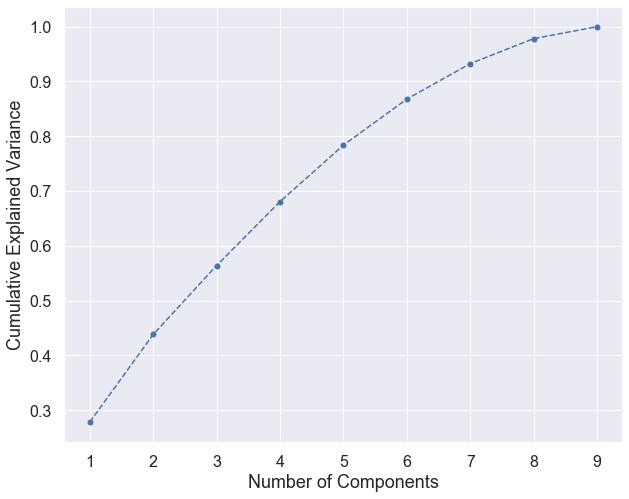

In [129]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(df_X.columns)+1), evr.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Cumulative Explained Variance',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig = plt.savefig("./visualizations/cumulative_variance_plot.png")
plt.show()

In [130]:
for i, exp_var in enumerate(evr.cumsum()):
    if exp_var >= 0.8:
        n_comps = i + 1
        break
print("Number of components:", n_comps)
pca = PCA(n_components=n_comps)
pca.fit(X_std)
scores_pca = pca.transform(X_std)

Number of components: 6


## K-Means Clustering

Finding the elbow point of the WCSS (within cluster sum of squares) curve using the YellowBrick `KElbowVisualizer`

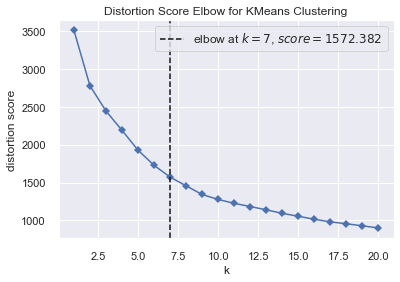

Optimal number of clusters: 7


In [131]:
visualizer = KElbowVisualizer(KMeans(init='k-means++', random_state=42), k=(1,21), timings=False)
visualizer.fit(scores_pca)
visualizer.show()
n_clusters = visualizer.elbow_value_
print("Optimal number of clusters:", n_clusters)

Finding the elbow point of the WCSS (within cluster sum of squares) curve using the kneed `KneeLocator`

In [132]:
wcss = []
max_clusters = 21
for i in range(1, max_clusters):
    kmeans_pca = KMeans(i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)
n_clusters = KneeLocator([i for i in range(1, max_clusters)], wcss, curve='convex', direction='decreasing').knee
print("Optimal number of clusters", n_clusters)

Optimal number of clusters 7


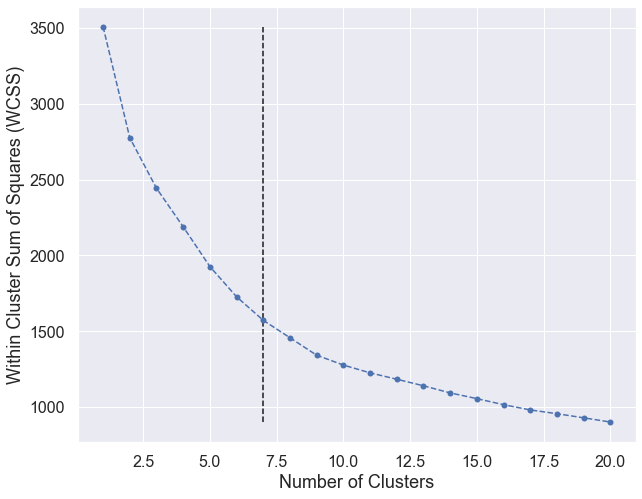

In [135]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
plt.vlines(KneeLocator([i for i in range(1, max_clusters)], wcss, curve='convex', direction='decreasing').knee, ymin=min(wcss), ymax=max(wcss), linestyles='dashed')
plt.xlabel('Number of Clusters', fontsize=18)
plt.ylabel('Within Cluster Sum of Squares (WCSS)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig.savefig("./visualizations/num_clusters.png")
plt.show()

In [137]:
kmeans_pca = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans_pca.fit(scores_pca);

## Analysis and Visualization

In [138]:
df_seg_pca_kmeans = pd.concat([df_X.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df_seg_pca_kmeans.columns.values[(-1*n_comps):] = ["Component " + str(i+1) for i in range(n_comps)]
df_seg_pca_kmeans['Cluster'] = kmeans_pca.labels_
df_seg_pca_kmeans.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Cluster
0,0.3590,0.785,0.530,0.001980,0.0774,-6.995,0.0634,146.380,0.729,-0.755875,-1.524784,0.670506,0.311032,-0.713421,-1.324086,1
1,0.7260,0.506,0.456,0.000037,0.1100,-10.635,0.0479,149.600,0.406,1.410067,0.045464,0.221830,0.959279,0.032394,-1.287393,3
2,0.3080,0.699,0.687,0.000036,0.1210,-3.997,0.1060,88.932,0.499,-1.373842,-1.032778,-0.747840,-0.505234,0.080663,0.484256,1
3,0.0792,0.696,0.558,0.000000,0.1620,-5.253,0.0512,113.000,0.217,-0.737866,0.087259,-0.882943,-0.209679,-0.060625,0.129295,0
4,0.7050,0.719,0.575,0.003340,0.0899,-5.436,0.0460,104.894,0.235,0.325974,-0.755708,-1.051295,-0.129976,-0.244270,-0.283174,3


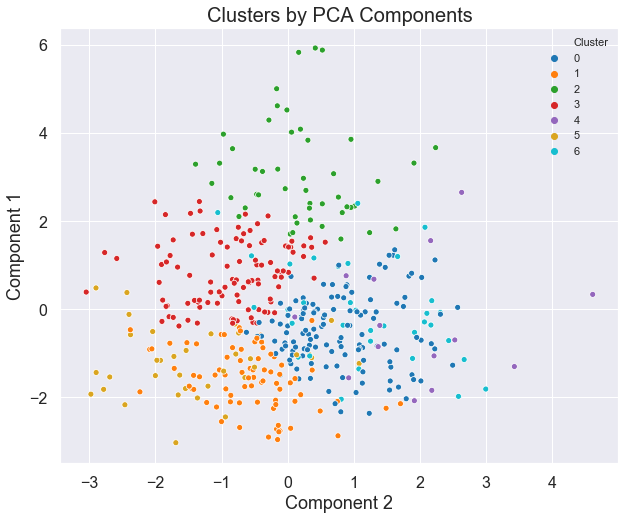

In [139]:
x = df_seg_pca_kmeans['Component 2']
y = df_seg_pca_kmeans['Component 1']
fig = plt.figure(figsize=(10, 8))
sns.scatterplot(x, y, hue=df_seg_pca_kmeans['Cluster'], palette = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'goldenrod', 'tab:cyan'])
plt.title('Clusters by PCA Components', fontsize=20)
plt.xlabel("Component 2", fontsize=18)
plt.ylabel("Component 1", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("./visualizations/clusters-2d.png")

In [140]:
df['Cluster'] = df_seg_pca_kmeans['Cluster']
df

,name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,playlist,Cluster
0,Way With Words,Bahamas,spotify:track:6ioeN8jQ8Qc3tS8dhpoAVi,0.35900,0.785,0.530,0.001980,0.0774,-6.995,0.0634,146.380,0.7290,twenty,1
1,Caroline,Briston Maroney,spotify:track:3S5mohVxC0Xuj0tgZ7vU7g,0.72600,0.506,0.456,0.000037,0.1100,-10.635,0.0479,149.600,0.4060,twenty,3
2,Hear Me Calling,Juice WRLD,spotify:track:13ZyrkCDmRz5xY3seuAWYk,0.30800,0.699,0.687,0.000036,0.1210,-3.997,0.1060,88.932,0.4990,twenty,1
3,94 Bentley,SAINt JHN,spotify:track:0xxbDtdmc88FOV7YvpEtft,0.07920,0.696,0.558,0.000000,0.1620,-5.253,0.0512,113.000,0.2170,twenty,0
4,I Feel Like I'm Drowning,Two Feet,spotify:track:5h0ODSutX73Vt4vZsmmph0,0.70500,0.719,0.575,0.003340,0.0899,-5.436,0.0460,104.894,0.2350,twenty,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,Lay Your Head On Me (feat. Marcus Mumford) - J...,Major Lazer,spotify:track:29v0kvBmnIurnEn34I2haX,0.00398,0.679,0.778,0.449000,0.2500,-6.063,0.0354,126.002,0.8760,twenty,1
445,Damn (feat. 6lack),Omah Lay,spotify:track:2SVObssPWzeJquNyR05NjL,0.32700,0.590,0.434,0.000000,0.1020,-5.975,0.2530,141.392,0.4930,twenty,5
446,Bubba,Jack Larsen,spotify:track:0qOe0oNsO7459dYDAlomiV,0.53300,0.285,0.539,0.003420,0.0995,-8.305,0.0273,170.007,0.0466,twenty,0
447,Perfect Blue,Elle Valenci,spotify:track:0u834tjHl0zB9xdPO5KrQX,0.89500,0.540,0.273,0.002230,0.1010,-12.123,0.0918,70.875,0.2860,twenty,2


In [91]:
for i in range(n_clusters):
    result = sp.user_playlist_create(user_config['username'], 'cluster'+str(i), public=True, collaborative=False, description='')
    playlist_id = result['id']
    songs = list(df.loc[df['Cluster'] == i]['track_URI'])
    if len(songs) > 100:
        sp.playlist_add_items(playlist_id, songs[:100])
        sp.playlist_add_items(playlist_id, songs[100:])
    else:
        sp.playlist_add_items(playlist_id, songs)


In [141]:
def make_normalized_df(df, col_sep):
    non_features = df[df.columns[:col_sep]]
    features = df[df.columns[col_sep:]]
    norm = MinMaxScaler().fit_transform(features)
    scaled = pd.DataFrame(norm, index=df.index, columns = df.columns[col_sep:])
    return pd.concat([non_features, scaled], axis=1)

cluster_labels = df['Cluster']
orig = df.drop(columns=['playlist', 'Cluster'])
values_df = make_normalized_df(orig, 3)
values_df.insert(3, 'cluster', cluster_labels)
values_df.head()

,name,artist,track_URI,cluster,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,Way With Words,Bahamas,spotify:track:6ioeN8jQ8Qc3tS8dhpoAVi,1,0.363700,0.791209,0.510822,0.002039,0.049421,0.766285,0.071573,0.524241,0.733418
1,Caroline,Briston Maroney,spotify:track:3S5mohVxC0Xuj0tgZ7vU7g,3,0.735550,0.450549,0.429108,0.000039,0.091377,0.587336,0.043054,0.545241,0.391727
2,Hear Me Calling,Juice WRLD,spotify:track:13ZyrkCDmRz5xY3seuAWYk,1,0.312026,0.686203,0.684187,0.000037,0.105534,0.913672,0.149954,0.149587,0.490109
3,94 Bentley,SAINt JHN,spotify:track:0xxbDtdmc88FOV7YvpEtft,0,0.080202,0.682540,0.541740,0.000000,0.158301,0.851925,0.049126,0.306549,0.191791
4,I Feel Like I'm Drowning,Two Feet,spotify:track:5h0ODSutX73Vt4vZsmmph0,3,0.714273,0.710623,0.560512,0.003440,0.065508,0.842928,0.039558,0.253685,0.210833


In [143]:
fig = make_subplots(rows=2, cols=4, specs=[[{'type': 'polar'}]*4]*2)

angles = list(values_df.columns[4:])
angles.append(angles[0])
abbrev = ["A", "D", "E", "I", "Li", "Lo", "S", "T", "V", "A"]

layoutdict = dict(
            radialaxis=dict(
            visible=True,
            range=[0, 1]
            ))

for i in range(n_clusters):
    subset = values_df[values_df['cluster'] == i]
    data = [np.mean(subset[col]) for col in subset.columns[4:]]
    data.append(data[0])
    fig.add_trace(go.Scatterpolar(
        r=data,
        theta=abbrev,
        fill='toself',
        name="Cluster " + str(i)),
        i // 4 + 1,
        i % 4 + 1)
    
fig.update_layout(
        polar=layoutdict,
        polar2=layoutdict,
        polar3=layoutdict,
        polar4=layoutdict,
        polar5=layoutdict,
        polar6=layoutdict,
        polar7=layoutdict,
        polar8=layoutdict,
        showlegend=True
        )
fig.show()
#     fig.write_image('./visualizations/cluster' + str(i) + '.png')

In [144]:
fig = go.Figure()

angles = list(values_df.columns[4:])
angles.append(angles[0])

layoutdict = dict(
            radialaxis=dict(
            visible=True,
            range=[0, 1]
            ))

for i in range(n_clusters):
    subset = values_df[values_df['cluster'] == i]
    data = [np.mean(subset[col]) for col in subset.columns[4:]]
    data.append(data[0])
    fig.add_trace(go.Scatterpolar(
        r=data,
        theta=angles,
        fill='toself',
        name="Cluster " + str(i)))
    
fig.update_layout(
        polar=layoutdict,
        showlegend=True
        )
fig.show()
#     fig.write_image('./visualizations/cluster' + str(i) + '.png')

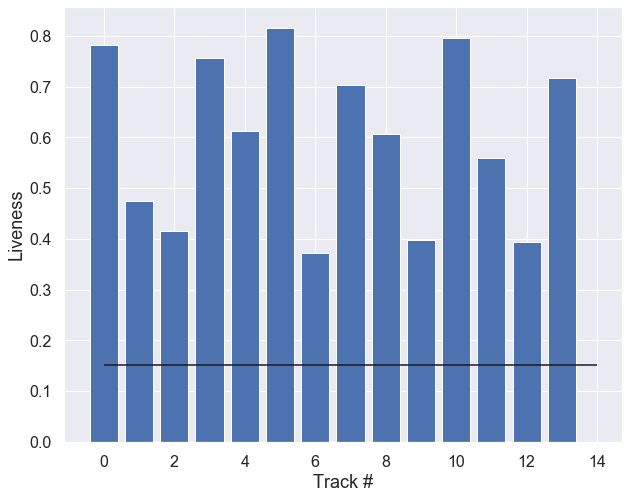

In [145]:
def inspect(df, param, cluster):
    plt.figure(figsize=(10,8))
    test_cluster = df.loc[df['Cluster'] == cluster]
    y = test_cluster[param]
    x = [i for i in range(len(y))]
    plt.bar(x, y)
    plt.xlabel('Track #', fontsize=18)
    plt.ylabel(param.title(), fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.hlines(np.mean(df[param]), 0, len(y))
    plt.show()
    
inspect(df, "liveness", 4)

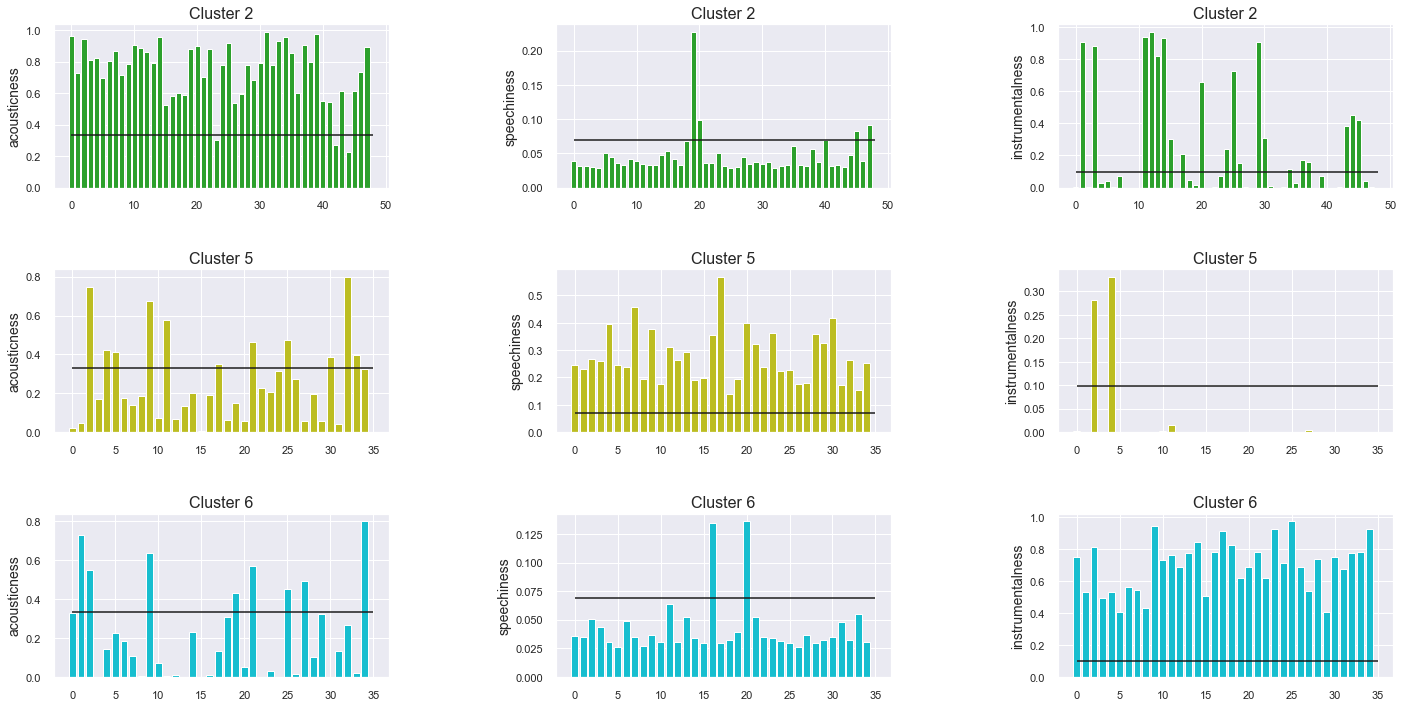

In [147]:
clusters = [2, 5, 6]
features = ["acousticness", "speechiness", "instrumentalness"]
colors = ['tab:green', 'tab:olive', 'tab:cyan']
dim = len(clusters)

fig, axes = plt.subplots(dim, dim, figsize=(24, 12))
i = 0
test_cluster = df.loc[df['Cluster'] == clusters[0]]
for ax in (axes.flatten()):
    if i % dim == 0 and i != 0:
        test_cluster = df.loc[df['Cluster'] == clusters[i // dim]]
    col = features[i % dim]
    y = test_cluster[col]
    x = [i for i in range(len(y))]
    ax.bar(x, y, color=colors[i//dim])
    ax.set_ylabel(col, fontsize=14)
    ax.set_title("Cluster " + str(clusters[i // dim]), fontsize=16)
    ax.hlines(np.mean(df[col]), 0, len(y))
    plt.subplots_adjust(wspace=.5, hspace=.5)
    i += 1
    
fig.savefig("./visualizations/cluster_feature_bar_charts_dim_3.png")

In [148]:
preview = df.loc[df['Cluster'] == 5]
print(len(preview))
preview.head(n=50)

35


,name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,playlist,Cluster
22,Everybody Lost Somebody,Bleachers,spotify:track:4JkOsslKrWDYYb5dcft9AH,0.02200,0.534,0.666,0.001550,0.0958,-8.724,0.245,183.737,0.254,twenty,5
30,BROWN SKIN GIRL,Blue Ivy,spotify:track:0B3FovCVaGKS5w1FTidEUP,0.04900,0.603,0.602,0.000000,0.2790,-7.083,0.230,119.703,0.595,twenty,5
34,Feathery - Slow Version,Milky Chance,spotify:track:798IyUjOzBkjliWev26j9j,0.74800,0.856,0.631,0.282000,0.0915,-11.252,0.268,93.980,0.546,twenty,5
71,XO,Beyoncé,spotify:track:40xhyfAPDoMtv494MfPevP,0.17100,0.470,0.792,0.000001,0.3130,-8.932,0.260,170.085,0.214,twenty,5
115,Cherry,Take/Five,spotify:track:0eeKPPnYhpEZPWzMpYN5bl,0.42500,0.627,0.721,0.331000,0.1080,-8.683,0.397,139.821,0.106,twenty,5
117,Scarlet Paintings - Stay Home Session,Milky Chance,spotify:track:0bu5JByHKJbZELYKw0vCnN,0.41300,0.482,0.819,0.000646,0.0621,-4.563,0.246,95.951,0.817,twenty,5
139,Monday,Kota the Friend,spotify:track:6FG3Th7J72vwIfUqVGSQ9z,0.17700,0.823,0.630,0.000000,0.2340,-7.120,0.239,100.030,0.580,twenty,5
146,last time,OSTON,spotify:track:5ZtiFgFIs1XHaYrAiE6I7S,0.14200,0.585,0.387,0.000000,0.0870,-9.156,0.458,79.403,0.351,twenty,5
154,Shoota (feat. Lil Uzi Vert),Playboi Carti,spotify:track:2BJSMvOGABRxokHKB0OI8i,0.18800,0.673,0.649,0.000000,0.1220,-8.433,0.196,153.075,0.470,twenty,5
169,Another Story (ft. M.anifest),Burna Boy,spotify:track:5TgGP38fQTuYO5ixyasQGq,0.67300,0.591,0.682,0.000026,0.1020,-6.705,0.378,110.669,0.955,twenty,5
